# Imports

In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, jaccard_score
import matplotlib.pyplot as plt
from PIL import Image
import os

# Cargar el dataset .npy

In [66]:
data = np.load('skin_nskin.npy')
X = data[:, :3].astype(np.float32) / 255.0  # Normaliza RGB c:
y = data[:, 3].astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [110]:
len(data)

245057

# Crear SkinDataset

In [83]:
class SkinDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear DataLoaders

In [84]:
def create_loaders(X_train, y_train, batch_size=128, balanced=True):
    train_dataset = SkinDataset(X_train, y_train)
    val_dataset = SkinDataset(X_val, y_val)
    if balanced:
        class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
        weights = 1. / class_sample_count
        target_weights = weights[(y_train).astype(int)]
        sampler = WeightedRandomSampler(target_weights, len(target_weights))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = create_loaders(X_train, y_train)

# Definir modelo MLP

In [69]:
def get_mlp(h1=8, h2=16, activation='relu', out_classes=1):
    act_fn = nn.ReLU() if activation == 'relu' else nn.Sigmoid()
    layers = [
        nn.Linear(3, h1),
        act_fn,
        nn.Linear(h1, h2),
        act_fn,
    ]
    if out_classes == 1:
        layers += [nn.Linear(h2, 1), nn.Sigmoid()]
    else:
        layers += [nn.Linear(h2, out_classes), nn.Softmax(dim=1)]
    return nn.Sequential(*layers)

# Entrenamiento

In [70]:
def train(model, loader, loss_fn, optimizer, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in loader:
            if isinstance(loss_fn, nn.CrossEntropyLoss):
                y_batch = y_batch.squeeze(1).long()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

# Evaluación y curva ROC

In [85]:
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch).numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    return np.array(all_labels).flatten(), np.array(all_preds).flatten()

def plot_roc(y_true, y_pred):
    thresholds = np.arange(0.2, 1.0, 0.1)
    tprs, fprs = [], []
    for t in thresholds:
        pred_bin = y_pred >= t
        tp = np.sum((pred_bin == 1) & (y_true == 1))
        fn = np.sum((pred_bin == 0) & (y_true == 1))
        fp = np.sum((pred_bin == 1) & (y_true == 0))
        tn = np.sum((pred_bin == 0) & (y_true == 0))
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tprs.append(tpr)
        fprs.append(fpr)
    plt.plot(fprs, tprs, marker='o')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.show()

# Experimentos

Epoch 1, Loss: 0.6569
Epoch 2, Loss: 0.3470
Epoch 3, Loss: 0.1916
Epoch 4, Loss: 0.1681
Epoch 5, Loss: 0.1572
Epoch 6, Loss: 0.1459
Epoch 7, Loss: 0.1328
Epoch 8, Loss: 0.1200
Epoch 9, Loss: 0.1062
Epoch 10, Loss: 0.0986
Epoch 11, Loss: 0.0893
Epoch 12, Loss: 0.0812
Epoch 13, Loss: 0.0760
Epoch 14, Loss: 0.0737
Epoch 15, Loss: 0.0708
Epoch 16, Loss: 0.0683
Epoch 17, Loss: 0.0634
Epoch 18, Loss: 0.0633
Epoch 19, Loss: 0.0619
Epoch 20, Loss: 0.0602
Epoch 21, Loss: 0.0572
Epoch 22, Loss: 0.0591
Epoch 23, Loss: 0.0559
Epoch 24, Loss: 0.0549
Epoch 25, Loss: 0.0542
Epoch 26, Loss: 0.0532
Epoch 27, Loss: 0.0504
Epoch 28, Loss: 0.0508
Epoch 29, Loss: 0.0488
Epoch 30, Loss: 0.0484


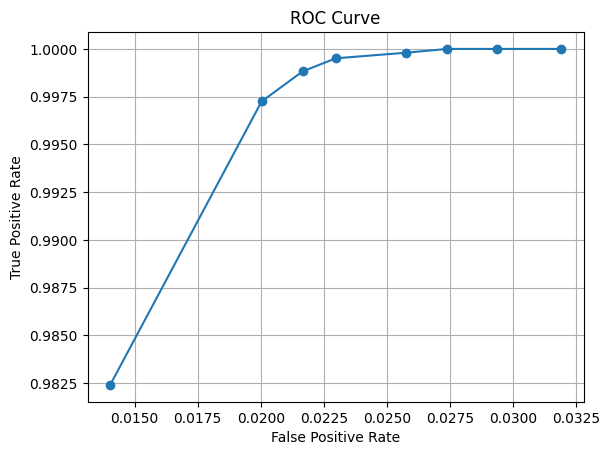

In [86]:
# Default ReLU
model_relu = get_mlp(8, 16, 'relu', 1)
train(model_relu, train_loader, nn.BCELoss(), optim.SGD(model_relu.parameters(), lr=0.01))
y_true_relu, y_pred_relu = evaluate(model_relu, val_loader)
plot_roc(y_true_relu, y_pred_relu)

Epoch 1, Loss: 0.6928
Epoch 2, Loss: 0.6924
Epoch 3, Loss: 0.6919
Epoch 4, Loss: 0.6914
Epoch 5, Loss: 0.6907
Epoch 6, Loss: 0.6897
Epoch 7, Loss: 0.6885
Epoch 8, Loss: 0.6868
Epoch 9, Loss: 0.6842
Epoch 10, Loss: 0.6804
Epoch 11, Loss: 0.6744
Epoch 12, Loss: 0.6647
Epoch 13, Loss: 0.6483
Epoch 14, Loss: 0.6206
Epoch 15, Loss: 0.5744
Epoch 16, Loss: 0.5063
Epoch 17, Loss: 0.4223
Epoch 18, Loss: 0.3435
Epoch 19, Loss: 0.2878
Epoch 20, Loss: 0.2522
Epoch 21, Loss: 0.2295
Epoch 22, Loss: 0.2164
Epoch 23, Loss: 0.2106
Epoch 24, Loss: 0.2018
Epoch 25, Loss: 0.1974
Epoch 26, Loss: 0.1930
Epoch 27, Loss: 0.1903
Epoch 28, Loss: 0.1888
Epoch 29, Loss: 0.1826
Epoch 30, Loss: 0.1828


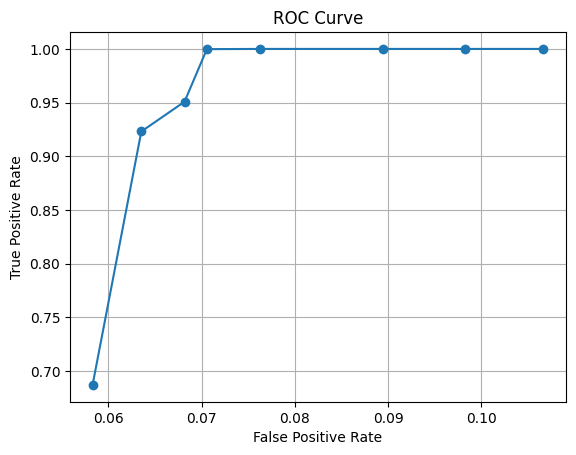

In [87]:
# Sigmoid internal activation
model_sigmoid = get_mlp(8, 16, 'sigmoid', 1)
train(model_sigmoid, train_loader, nn.BCELoss(), optim.SGD(model_sigmoid.parameters(), lr=0.01))
y_true_sigmoid, y_pred_sigmoid = evaluate(model_sigmoid, val_loader)
plot_roc(y_true_sigmoid, y_pred_sigmoid)

Epoch 1, Loss: 0.6820
Epoch 2, Loss: 0.5900
Epoch 3, Loss: 0.4092
Epoch 4, Loss: 0.3697
Epoch 5, Loss: 0.3616
Epoch 6, Loss: 0.3583
Epoch 7, Loss: 0.3560
Epoch 8, Loss: 0.3552
Epoch 9, Loss: 0.3540
Epoch 10, Loss: 0.3537
Epoch 11, Loss: 0.3526
Epoch 12, Loss: 0.3523
Epoch 13, Loss: 0.3520
Epoch 14, Loss: 0.3521
Epoch 15, Loss: 0.3516
Epoch 16, Loss: 0.3527
Epoch 17, Loss: 0.3516
Epoch 18, Loss: 0.3510
Epoch 19, Loss: 0.3514
Epoch 20, Loss: 0.3512
Epoch 21, Loss: 0.3515
Epoch 22, Loss: 0.3511
Epoch 23, Loss: 0.3514
Epoch 24, Loss: 0.3507
Epoch 25, Loss: 0.3504
Epoch 26, Loss: 0.3500
Epoch 27, Loss: 0.3506
Epoch 28, Loss: 0.3513
Epoch 29, Loss: 0.3502
Epoch 30, Loss: 0.3510


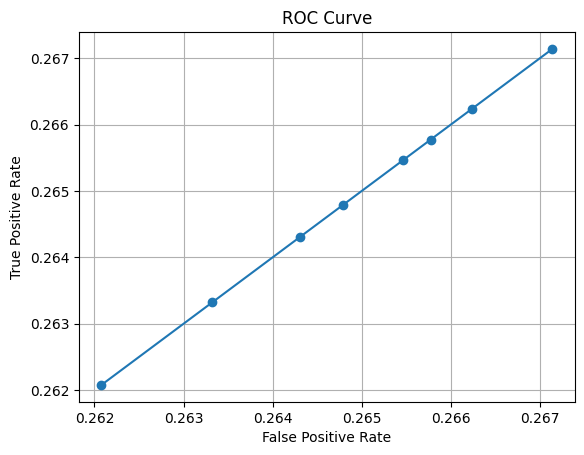

In [88]:
# 2 output neurons + softmax + crossentropy
train_loader_ce, val_loader_ce = create_loaders(X_train, y_train, balanced=True)
train_dataset_ce = SkinDataset(X_train, y_train.astype(int))
train_loader_ce = DataLoader(train_dataset_ce, batch_size=128, sampler=train_loader_ce.sampler)
val_dataset_ce = SkinDataset(X_val, y_val.astype(int))
val_loader_ce = DataLoader(val_dataset_ce, batch_size=128, shuffle=False)

model_softmax = get_mlp(8, 16, 'relu', 2)
train(model_softmax, train_loader_ce, nn.CrossEntropyLoss(), optim.SGD(model_softmax.parameters(), lr=0.01))

def evaluate_ce(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            out = model(X_batch).numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(out[:, 1])
    return np.array(y_true), np.array(y_pred)

y_true_softmax, y_pred_softmax = evaluate_ce(model_softmax, val_loader_ce)
plot_roc(y_true_softmax, y_pred_softmax)

Epoch 1, Loss: 0.5230
Epoch 2, Loss: 0.3651
Epoch 3, Loss: 0.2018
Epoch 4, Loss: 0.1704
Epoch 5, Loss: 0.1579
Epoch 6, Loss: 0.1473
Epoch 7, Loss: 0.1360
Epoch 8, Loss: 0.1233
Epoch 9, Loss: 0.1104
Epoch 10, Loss: 0.1001
Epoch 11, Loss: 0.0935
Epoch 12, Loss: 0.0889
Epoch 13, Loss: 0.0848
Epoch 14, Loss: 0.0822
Epoch 15, Loss: 0.0803
Epoch 16, Loss: 0.0789
Epoch 17, Loss: 0.0776
Epoch 18, Loss: 0.0764
Epoch 19, Loss: 0.0753
Epoch 20, Loss: 0.0741
Epoch 21, Loss: 0.0730
Epoch 22, Loss: 0.0717
Epoch 23, Loss: 0.0705
Epoch 24, Loss: 0.0692
Epoch 25, Loss: 0.0679
Epoch 26, Loss: 0.0666
Epoch 27, Loss: 0.0653
Epoch 28, Loss: 0.0641
Epoch 29, Loss: 0.0628
Epoch 30, Loss: 0.0615


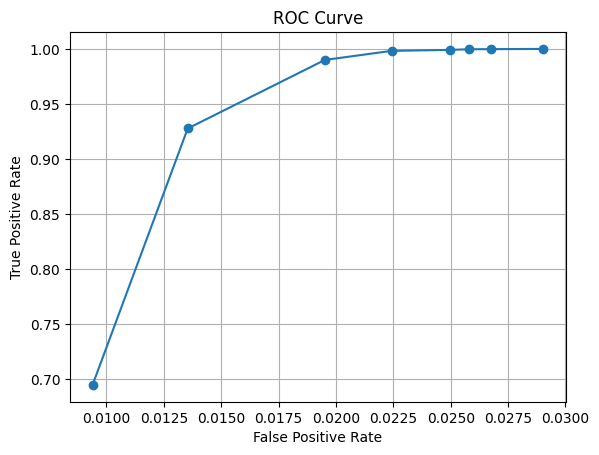

In [89]:
# Unbalanced batches - no samplerr
unbalanced_loader, _ = create_loaders(X_train, y_train, balanced=False)
model_unbalanced = get_mlp(8, 16, 'relu', 1)
train(model_unbalanced, unbalanced_loader, nn.BCELoss(), optim.SGD(model_unbalanced.parameters(), lr=0.01))
y_true_ub, y_pred_ub = evaluate(model_unbalanced, val_loader)
plot_roc(y_true_ub, y_pred_ub)

Epoch 1, Loss: 0.6831
Epoch 2, Loss: 0.5703
Epoch 3, Loss: 0.2844
Epoch 4, Loss: 0.2293
Epoch 5, Loss: 0.2182
Epoch 6, Loss: 0.2062
Epoch 7, Loss: 0.1996
Epoch 8, Loss: 0.1864
Epoch 9, Loss: 0.1679
Epoch 10, Loss: 0.1471
Epoch 11, Loss: 0.1230
Epoch 12, Loss: 0.1071
Epoch 13, Loss: 0.0991
Epoch 14, Loss: 0.0909
Epoch 15, Loss: 0.0857
Epoch 16, Loss: 0.0806
Epoch 17, Loss: 0.0783
Epoch 18, Loss: 0.0753
Epoch 19, Loss: 0.0755
Epoch 20, Loss: 0.0706
Epoch 21, Loss: 0.0706
Epoch 22, Loss: 0.0698
Epoch 23, Loss: 0.0681
Epoch 24, Loss: 0.0681
Epoch 25, Loss: 0.0671
Epoch 26, Loss: 0.0662
Epoch 27, Loss: 0.0652
Epoch 28, Loss: 0.0654
Epoch 29, Loss: 0.0645
Epoch 30, Loss: 0.0628


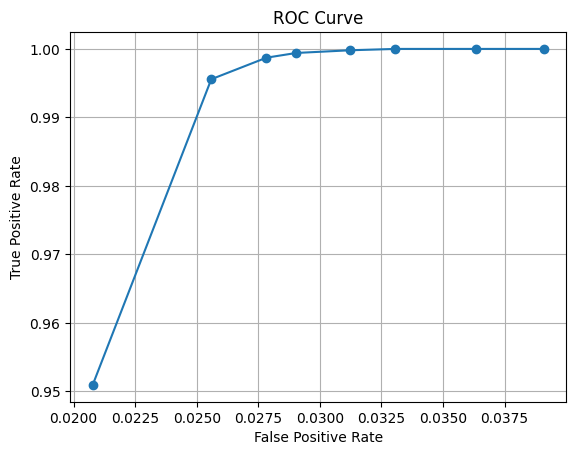

In [90]:
# Reduced 4, 8
model_small = get_mlp(4, 8, 'relu', 1)
train(model_small, train_loader, nn.BCELoss(), optim.SGD(model_small.parameters(), lr=0.01))
y_true_small, y_pred_small = evaluate(model_small, val_loader)
plot_roc(y_true_small, y_pred_small)

# Curvas ROC juntas

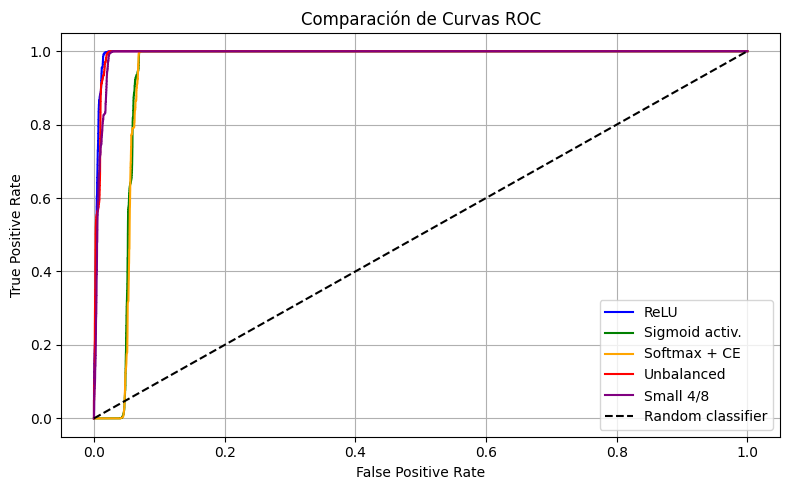

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve

def compute_roc(model, dataloader, device):
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            if outputs.shape[1] == 1:
                probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
            elif outputs.shape[1] == 2:
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            else:
                raise ValueError("Modelo con número de salidas inesperado")

            all_probs.extend(probs)
            all_targets.extend(targets.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    return fpr, tpr, thresholds

model_names = {
    "model_relu": "ReLU",
    "model_sigmoid": "Sigmoid activ.",
    "model_softmax": "Softmax + CE",
    "model_unbalanced": "Unbalanced",
    "model_small": "Small 4/8"
}

colors = {
    "model_relu": "blue",
    "model_sigmoid": "green",
    "model_softmax": "orange",
    "model_unbalanced": "red",
    "model_small": "purple"
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(8, 5))

for model_var in model_names.keys():
    model = globals()[model_var].to(device)
    fpr, tpr, _ = compute_roc(model, val_loader, device=device)
    plt.plot(fpr, tpr, label=model_names[model_var], color=colors[model_var])

plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de Curvas ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Imagenes

In [91]:
def predict_on_image(model, image_path, threshold=0.5):
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img).astype(np.float32) / 255.0
    h, w, _ = img_np.shape
    pixels = img_np.reshape(-1, 3)
    with torch.no_grad():
        output = model(torch.tensor(pixels)).numpy().flatten()
    mask = (output >= threshold).astype(np.uint8).reshape(h, w)
    return img_np, mask

def segment_and_evaluate(image_path, mask_path, model):
    img = Image.open(image_path).convert("RGB")
    mask_img = Image.open(mask_path).convert("L")
    mask_gt = (np.array(mask_img) > 127).astype(np.uint8)

    img_np, pred_mask = predict_on_image(model, image_path)
    segmented = (img_np * pred_mask[..., None] * 255).astype(np.uint8)

    acc = accuracy_score(mask_gt.flatten(), pred_mask.flatten())
    iou = jaccard_score(mask_gt.flatten(), pred_mask.flatten())

    return img_np, segmented, mask_gt, pred_mask, acc, iou

folder = 'dataset_with_mask'
all_files = os.listdir(folder)
jpg_files = sorted([f for f in all_files if f.endswith('.jpg')])

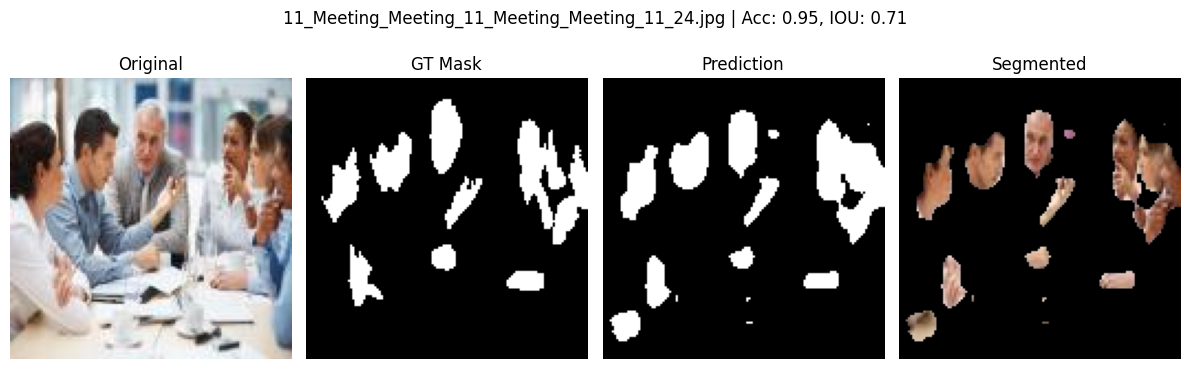

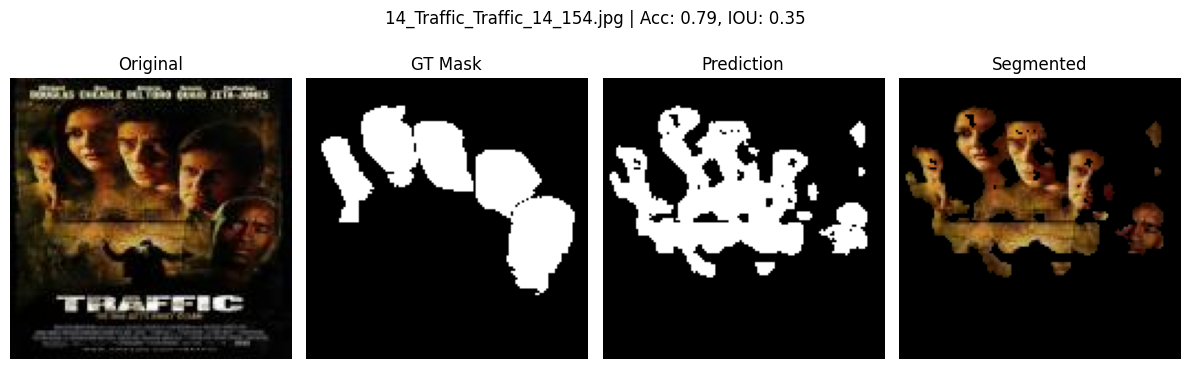

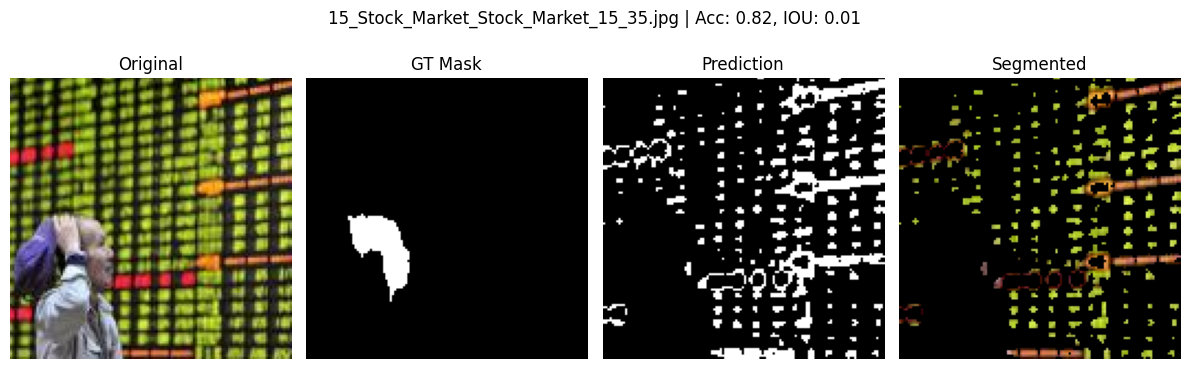

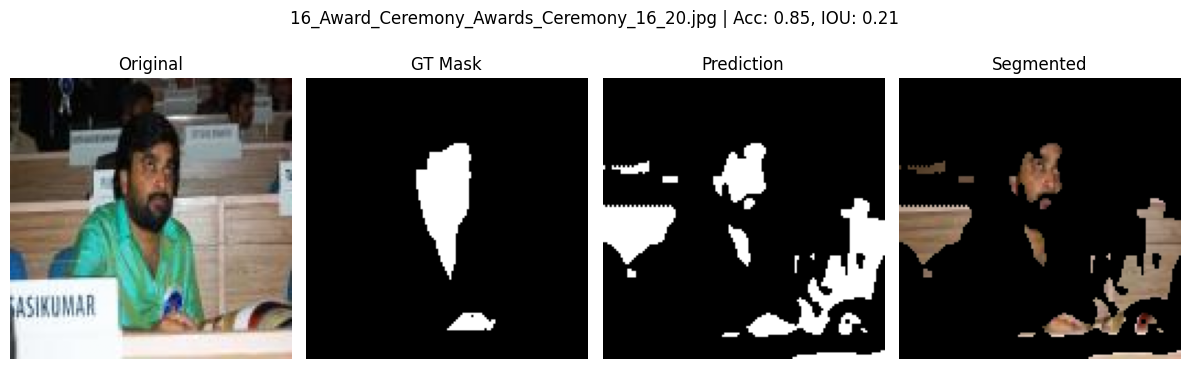

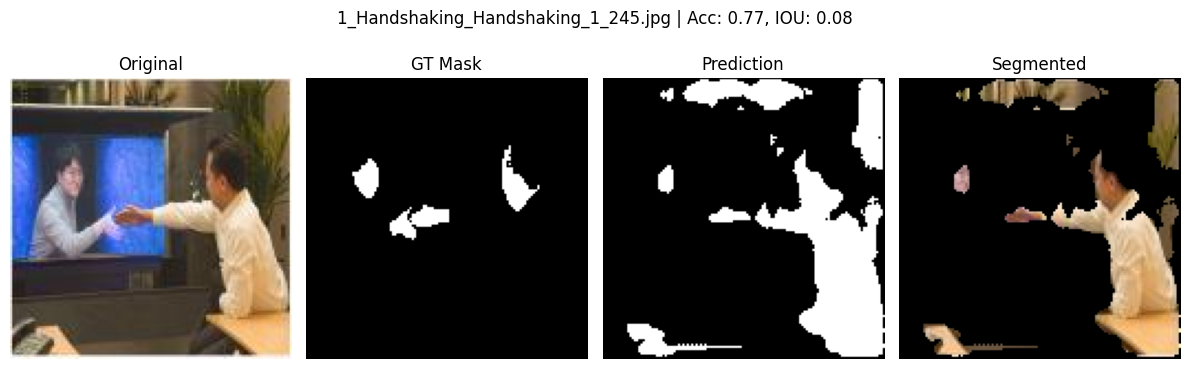

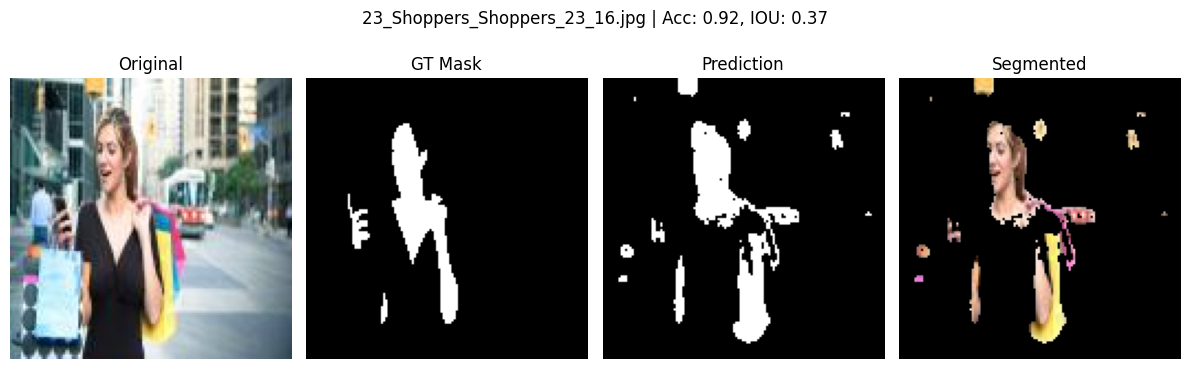

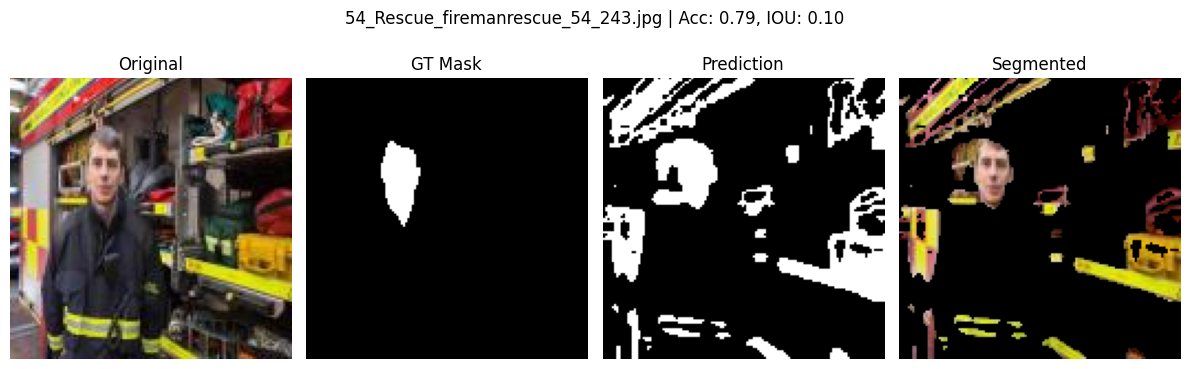

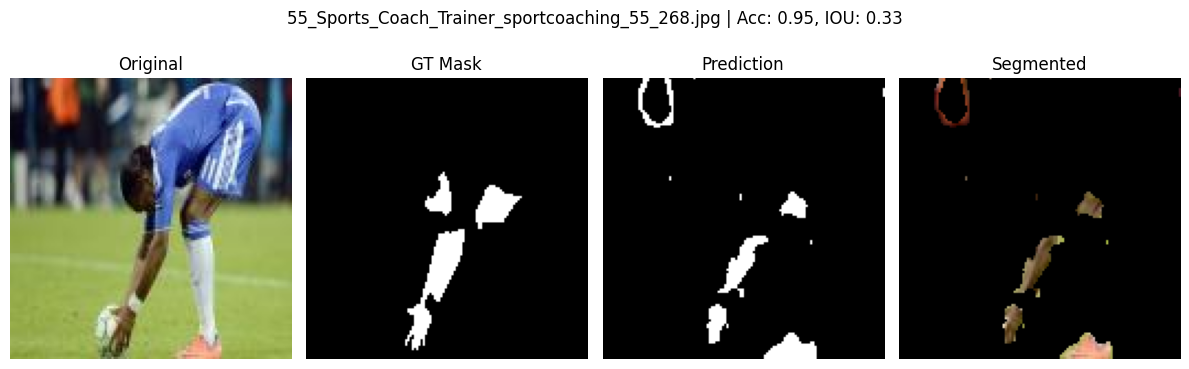

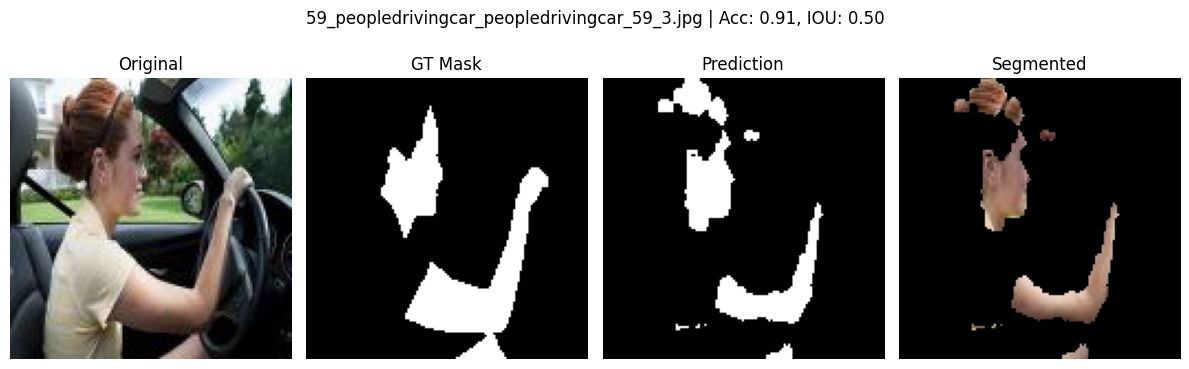

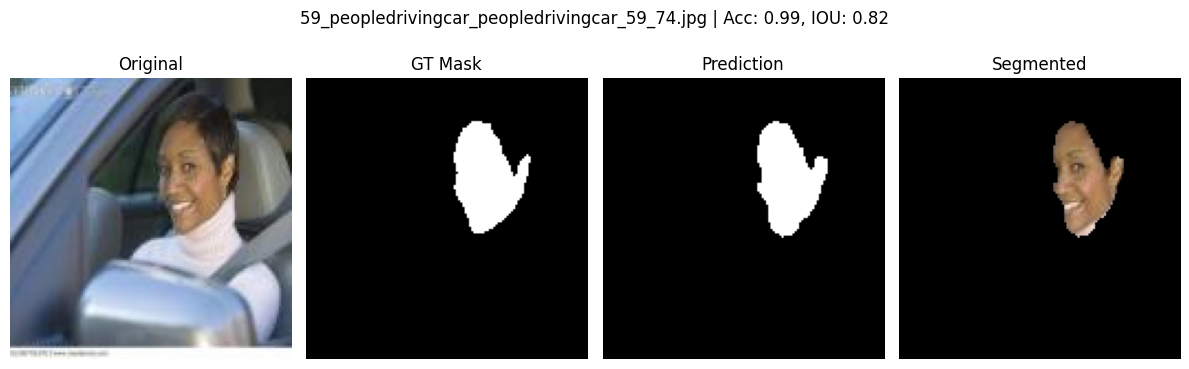

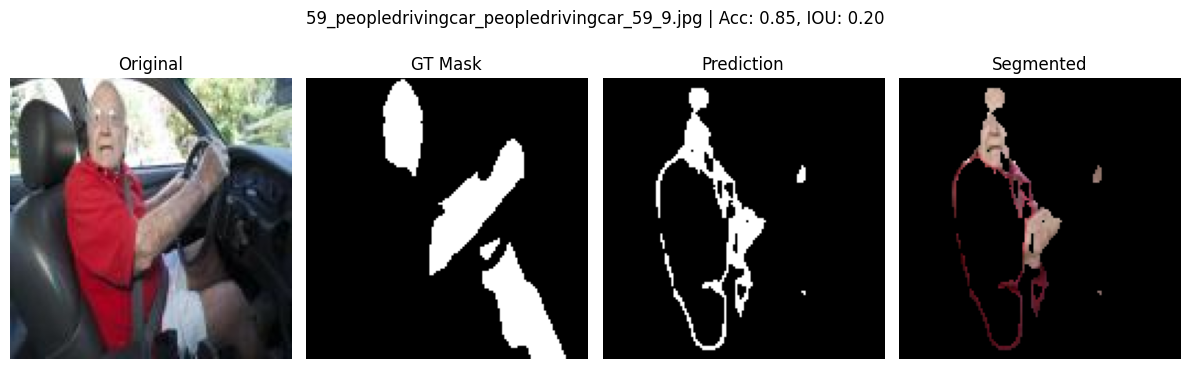

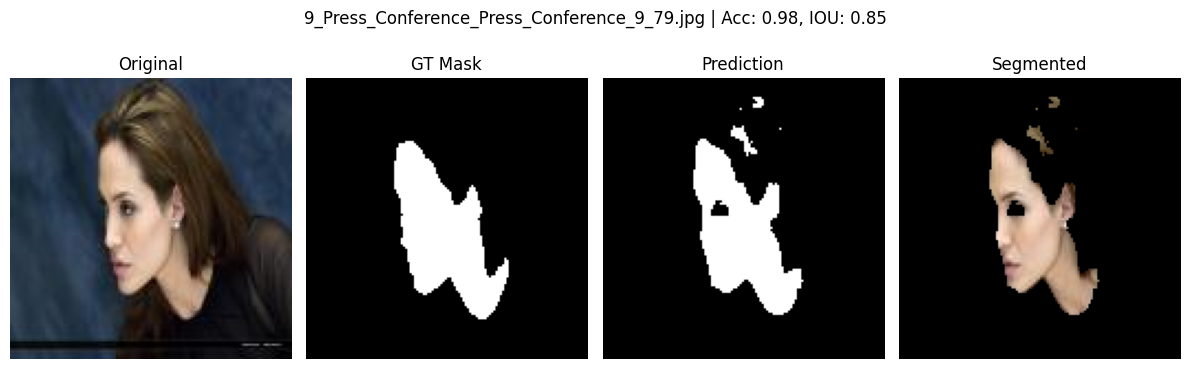

In [102]:
for jpg in jpg_files[:12]:
    base = jpg.replace('.jpg', '')
    mask = base + '_mask.png'
    img_path = os.path.join(folder, jpg)
    mask_path = os.path.join(folder, mask)
    if not os.path.exists(mask_path):
        continue
    orig, segm, real, pred, acc, iou = segment_and_evaluate(img_path, mask_path, model_relu)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1); plt.imshow(orig); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(real, cmap='gray'); plt.title("GT Mask"); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(pred, cmap='gray'); plt.title("Prediction"); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(segm); plt.title("Segmented"); plt.axis('off')
    plt.suptitle(f"{jpg} | Acc: {acc:.2f}, IOU: {iou:.2f}")
    plt.tight_layout()
    plt.show()

## Metricas relavantes

In [117]:
from sklearn.metrics import accuracy_score, jaccard_score
from sklearn.metrics import roc_auc_score

def compute_auc(y_true, y_pred_prob):
    return roc_auc_score(y_true, y_pred_prob)

def compute_metrics(y_true, y_pred_prob, threshold=0.5):
    y_pred_bin = (y_pred_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred_bin)
    iou = jaccard_score(y_true, y_pred_bin)
    return acc, iou

    #"model_relu": "ReLU",
    #"model_sigmoid": "Sigmoid activ.",
    #"model_softmax": "Softmax + CE",
    #"model_unbalanced": "Unbalanced",
    #"model_small": "Small 4/8"

acc_relu, iou_relu = compute_metrics(y_true_relu, y_pred_relu)
auc_relu = compute_auc(y_true_relu, y_pred_relu)
print("Relu: ", acc_relu, iou_relu, auc_relu)

acc_sigmoid, iou_sigmoid = compute_metrics(y_true_sigmoid, y_pred_sigmoid)
auc_sigmoid = compute_auc(y_true_sigmoid, y_pred_sigmoid)
print("sigmoid: ", acc_sigmoid, iou_sigmoid, auc_sigmoid)

acc_softmax, iou_softmax = compute_metrics(y_true_softmax, y_pred_softmax)
auc_softmax = compute_auc(y_true_softmax, y_pred_softmax)
print("softmax: ", acc_softmax, iou_softmax, auc_softmax)

acc_unbalanced, iou_unbalanced = compute_metrics(y_true_ub, y_pred_ub)
auc_unbalanced = compute_auc(y_true_ub, y_pred_ub)
print("unbalanced: ", acc_unbalanced, iou_unbalanced, auc_unbalanced)

acc_small, iou_small = compute_metrics(y_true_small, y_pred_small)
auc_small = compute_auc(y_true_small, y_pred_small)
print("small: ", acc_small, iou_small, auc_small)

Relu:  0.9795356239288338 0.9102300187953101 0.99551347487479
sigmoid:  0.9395454174487881 0.7744194899124477 0.9457675686736029
softmax:  0.942075410103648 0.7818000153716086 0.9446415019036122
unbalanced:  0.9800252999265486 0.9121342667384671 0.9943379726075051
small:  0.975210152615686 0.8932806324110671 0.9922934929612316
